In [ ]:
import networkx as nx # create an empty graph
G=nx.Graph()

In [ ]:
# create example graph for R2 with weights on edges, weight 1 means toll road to distinguish from non toll roads with weight 0
G.add_edges_from([(3, 9, {'weight': 2}),(1, 4, {'weight': 1}), (1, 9,{'weight': 1}), (4,9,{'weight': 1}), (9,2, {'weight': 1}), (9,7, {'weight': 1}), (2,7, {'weight': 1}),  (2,5, {'weight': 2}),  (7,5, {'weight': 1}),  (7,8,{'weight': 2}), (5,6, {'weight': 1}), (5,8, {'weight': 1}), (5,10, {'weight': 2}),(8,6, {'weight': 2}),(8,10, {'weight': 1})])

node degree
3 1
9 5
1 2
4 2
2 3
7 4
5 5
8 4
6 2
10 2

the adjacency list
3 9
9 1 4 2 7
1 4
4
2 7 5
7 5 8
5 6 8 10
8 6 10
6
10
{(3, 9): 2, (9, 1): 1, (9, 4): 1, (9, 2): 1, (9, 7): 1, (1, 4): 1, (2, 7): 1, (2, 5): 2, (7, 5): 1, (7, 8): 2, (5, 6): 1, (5, 8): 1, (5, 10): 2, (8, 6): 2, (8, 10): 1}


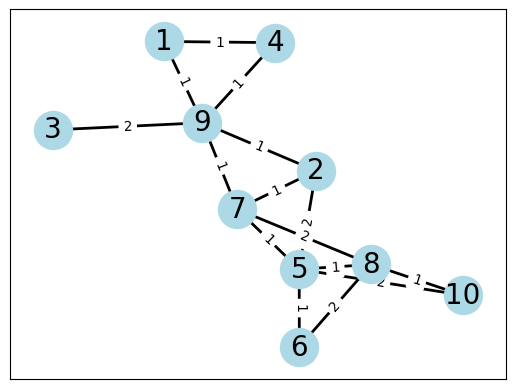

In [ ]:
import matplotlib.pyplot as plt # routine to plot the example graph

# some properties
print("node degree")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', linewidths=0.05) # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=2)                               # draw edges

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G, 'weight','trips')
print(edge_labels)
#print("%.2f" % edge_labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()


In [ ]:
from datetime import datetime, timedelta

# Define the Van class
class Van:
    def __init__(self, van_id, current_node=1):
        self.id = van_id
        self.current_node = current_node
        self.service_queue = []  # list of (pickup, dropoff)
        self.path = []  # list of nodes to traverse
        self.traversal_remaining_time = 0  # ticks remaining to traverse current edge

    def __repr__(self):
        return f"Van {self.id}: Node {self.current_node}, Queue {self.service_queue}, Path {self.path}"

# Function to assign a van to a customer request based on proximity
def assign_van(vans, start_loc):
    # Find available vans (all have capacity 6, so always available)
    # Choose the van with the shortest distance to pickup location
    available_vans = vans
    if not available_vans:
        return None
    # Find the nearest available van
    nearest_van = min(available_vans, key=lambda v: nx.shortest_path_length(G, v.current_node, start_loc, weight='weight'))
    return nearest_van

# Function to get the path from current node to target node
def get_path(current_node, target_node):
    try:
        path = nx.shortest_path(G, current_node, target_node, weight='weight')
        return path[1:]  # Exclude current_node
    except nx.NetworkXNoPath:
        return []

# Function to move the van
def move_van(van):
    if van.traversal_remaining_time > 0:
        # Currently traversing an edge
        van.traversal_remaining_time -= 1
        if van.traversal_remaining_time == 0:
            # Arrived at next node
            if van.path:
                next_node = van.path.pop(0)
                van.current_node = next_node
                print(f"Van {van.id} arrived at node {next_node}.")

                # Handle drop-offs at this node
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)

                # Handle pickups at this node
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    # After pickup, add path to dropoff
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        # Set traversal_remaining_time for the next edge
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight
    else:
        if van.path:
            # Start moving to next node
            next_node = van.path.pop(0)
            edge_weight = G[van.current_node][next_node]['weight']
            # Set traversal_remaining_time based on edge weight
            van.traversal_remaining_time = edge_weight - 1
            print(f"Van {van.id} starts moving to node {next_node} with traversal time {edge_weight}.")

            if edge_weight == 1:
                # Arrive immediately at next node
                van.current_node = next_node
                print(f"Van {van.id} arrived at node {next_node}.")

                # Handle drop-offs at this node
                dropoffs = [req for req in van.service_queue if req[1] == next_node]
                for req in dropoffs:
                    print(f"Van {van.id} dropping off customer at node {next_node}.")
                    van.service_queue.remove(req)

                # Handle pickups at this node
                pickups = [req for req in van.service_queue if req[0] == next_node]
                for req in pickups:
                    print(f"Van {van.id} picking up customer at node {next_node}.")
                    # After pickup, add path to dropoff
                    dropoff_path = get_path(van.current_node, req[1])
                    van.path += dropoff_path
                    if dropoff_path:
                        # Set traversal_remaining_time for the next edge
                        next_step = van.path[0]
                        edge_weight = G[van.current_node][next_step]['weight']
                        van.traversal_remaining_time = edge_weight
            else:
                # Set traversal_remaining_time for the current edge
                van.traversal_remaining_time = edge_weight

# Function to handle customer assignments
def handle_customer_requests(vans, requests):
    for pickup, dropoff in requests:
        van = assign_van(vans, pickup)
        if van:
            print(f"Assigning Van {van.id} to customer: Pickup at {pickup}, Drop off at {dropoff}")
            van.service_queue.append((pickup, dropoff))
            # If the van is idle (no path), set path to pickup
            if not van.path:
                path_to_pickup = get_path(van.current_node, pickup)
                van.path += path_to_pickup
                if path_to_pickup:
                    # Set traversal_remaining_time for the first edge
                    next_step = van.path[0]
                    edge_weight = G[van.current_node][next_step]['weight']
                    van.traversal_remaining_time = edge_weight
        else:
            print("No available vans for this request.")

# Main simulation function
def simulate_cab_service(start_time, end_time):
    # Initialize 2 vans at node1
    vans = [Van(van_id=1), Van(van_id=2)]

    # Define customer requests per clock tick
    customer_requests_per_tick = {
        1: [(1, 9), (2, 6)],
        2: [(5, 7), (3, 4)],
        3: [(4, 7), (2, 10)]
    }

    current_time = start_time
    clock_tick = 1

    while current_time < end_time and clock_tick <=3:
        print(f"\nClock tick {clock_tick}: {current_time.strftime('%I:%M %p')}")
        # Assign customer requests for this tick
        requests = customer_requests_per_tick.get(clock_tick, [])
        handle_customer_requests(vans, requests)

        # Move all vans
        for van in vans:
            move_van(van)

        # Print service queues and paths
        for van in vans:
            print(f"S{van.id}: {van.service_queue}")
            print(f"P{van.id}: {van.path}")

        print("-" * 50)

        # Increment time and clock tick
        current_time += timedelta(minutes=1)
        clock_tick +=1

    print("Simulation ended.")

# Run the simulation for 3 ticks from 8:00AM to 8:03AM
start_time = datetime.strptime("08:00", "%H:%M")
end_time = start_time + timedelta(minutes=3)
simulate_cab_service(start_time, end_time)


Clock tick 1: 08:00 AM
Assigning Van 1 to customer: Pickup at 1, Drop off at 9
Assigning Van 1 to customer: Pickup at 2, Drop off at 6
Van 1 arrived at node 9.
Van 1 dropping off customer at node 9.
S1: [(2, 6)]
P1: [2]
S2: []
P2: []
--------------------------------------------------

Clock tick 2: 08:01 AM
Assigning Van 1 to customer: Pickup at 5, Drop off at 7
Assigning Van 1 to customer: Pickup at 3, Drop off at 4
Van 1 starts moving to node 2 with traversal time 1.
Van 1 arrived at node 2.
Van 1 picking up customer at node 2.
S1: [(2, 6), (5, 7), (3, 4)]
P1: [5, 6]
S2: []
P2: []
--------------------------------------------------

Clock tick 3: 08:02 AM
Assigning Van 2 to customer: Pickup at 4, Drop off at 7
Assigning Van 1 to customer: Pickup at 2, Drop off at 10
Van 2 arrived at node 4.
Van 2 picking up customer at node 4.
S1: [(2, 6), (5, 7), (3, 4), (2, 10)]
P1: [5, 6]
S2: [(4, 7)]
P2: [9, 7]
--------------------------------------------------
Simulation ended.


In [ ]:
nx.dijkstra_path(G,2,1)  #  Find the length of the shortest path using Dijsktra's algorithm

[2, 9, 1]

In [ ]:
nx.astar_path(G,2,1) # Find the length of the shortest path using the A* algorithm.

[2, 9, 1]